In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)


2.17.0


In [2]:
# Define the dataset path
dataset_path = 'D:/COURSES/MACHINE LEARNING/Food Calorie Recognition'

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\calorie.h5
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\calorie.ipynb
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\calories.py
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\FCR.h5
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\FCR_modeltraining.ipynb
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\food.py
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\foodcalorierecognition.ipynb
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\Food_Calorie_Recognition_Model.h5
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\streamlit_app.py
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\.ipynb_checkpoints\calorie-checkpoint.ipynb
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\.ipynb_checkpoints\FCR_modeltraining-checkpoint.ipynb
D:/COURSES/MACHINE LEARNING/Food Calorie Recognition\.ipynb_checkpoints\foodcalorierecognition-checkpoint.ipynb
D:/COURSES/MACHINE LEARNING/Food Calorie Recognitio

In [3]:
# Create a list with the filepaths for training and testing
train_dir = Path(os.path.join(dataset_path, 'train'))
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(os.path.join(dataset_path, 'test'))
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(os.path.join(dataset_path, 'validation'))
val_filepaths = list(val_dir.glob(r'**/*.jpg'))


In [4]:
def image_processing(filepath):
    """Create a DataFrame with the filepath and the labels of the pictures"""
    labels = []
    for file in filepath:
        parts = os.path.normpath(file).split(os.sep)
        if len(parts) > 1:
            labels.append(parts[-2])
        else:
            labels.append("Unknown")

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


In [5]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [6]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['bell pepper' 'corn' 'kiwi' 'lettuce' 'tomato' 'turnip' 'ginger' 'carrot'
 'cucumber' 'pomegranate' 'lemon' 'pineapple' 'watermelon' 'cabbage'
 'jalepeno' 'soy beans' 'grapes' 'potato' 'sweetpotato' 'capsicum'
 'garlic' 'onion' 'sweetcorn' 'orange' 'cauliflower' 'mango' 'pear'
 'eggplant' 'paprika' 'peas' 'spinach' 'raddish' 'chilli pepper'
 'beetroot' 'apple' 'banana']


In [7]:
train_df.head(5)

,Filepath,Label
0,D:\COURSES\MACHINE LEARNING\Food Calorie Recog...,bell pepper
1,D:\COURSES\MACHINE LEARNING\Food Calorie Recog...,corn
2,D:\COURSES\MACHINE LEARNING\Food Calorie Recog...,corn
3,D:\COURSES\MACHINE LEARNING\Food Calorie Recog...,kiwi
4,D:\COURSES\MACHINE LEARNING\Food Calorie Recog...,corn


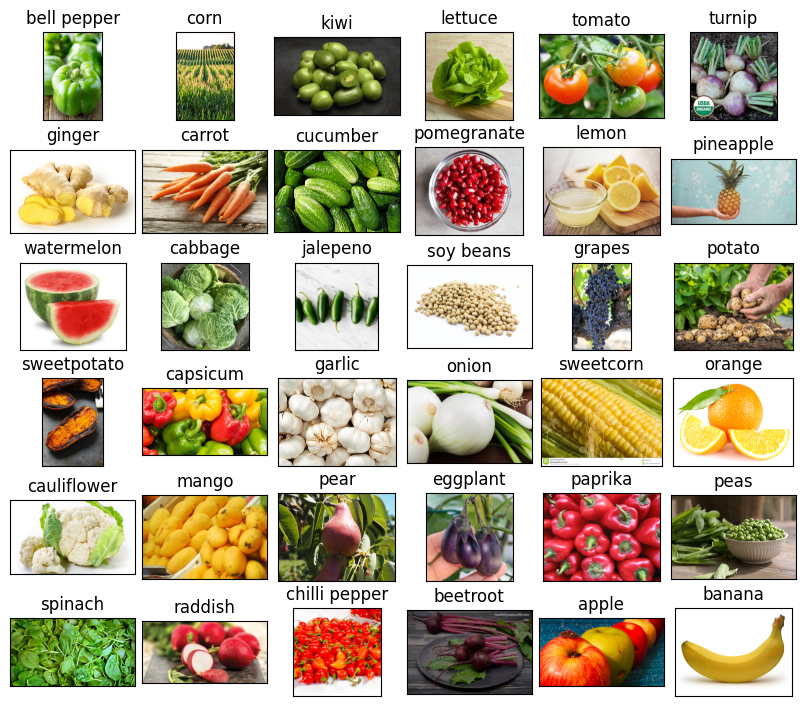

In [8]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [11]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [12]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [14]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


C:\Users\shubh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3373 - loss: 2.5382 - val_accuracy: 0.8500 - val_loss: 0.5103
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8049 - loss: 0.5777 - val_accuracy: 0.9265 - val_loss: 0.2880
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.8966 - loss: 0.3299 - val_accuracy: 0.9647 - val_loss: 0.2044
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9359 - loss: 0.2173 - val_accuracy: 0.9382 - val_loss: 0.1938
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9581 - loss: 0.1453 - val_accuracy: 0.9441 - val_loss: 0.1716


In [15]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step


['lettuce',
 'peas',
 'banana',
 'onion',
 'banana',
 'bell pepper',
 'jalepeno',
 'chilli pepper',
 'kiwi',
 'sweetpotato',
 'spinach',
 'tomato',
 'beetroot',
 'spinach',
 'turnip',
 'apple',
 'bell pepper',
 'onion',
 'soy beans',
 'turnip',
 'banana',
 'capsicum',
 'lettuce',
 'pineapple',
 'paprika',
 'turnip',
 'raddish',
 'grapes',
 'sweetcorn',
 'sweetcorn',
 'ginger',
 'banana',
 'paprika',
 'raddish',
 'lettuce',
 'watermelon',
 'capsicum',
 'ginger',
 'beetroot',
 'onion',
 'spinach',
 'pomegranate',
 'beetroot',
 'sweetcorn',
 'grapes',
 'potato',
 'garlic',
 'orange',
 'capsicum',
 'watermelon',
 'cauliflower',
 'paprika',
 'chilli pepper',
 'sweetpotato',
 'chilli pepper',
 'lettuce',
 'garlic',
 'lemon',
 'pineapple',
 'tomato',
 'cabbage',
 'pomegranate',
 'ginger',
 'jalepeno',
 'cauliflower',
 'chilli pepper',
 'beetroot',
 'cabbage',
 'sweetpotato',
 'watermelon',
 'bell pepper',
 'bell pepper',
 'mango',
 'eggplant',
 'spinach',
 'banana',
 'pomegranate',
 'lettuce'

In [16]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [17]:
img = output('D:/COURSES/MACHINE LEARNING/Food Calorie Recognition/test/cabbage/Image_1.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'cabbage'

In [18]:
model.save('FoodCalorieRecognition.h5')